# Handwriting recognition

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

## Data import and visualization

Import the MNIST train dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database))

In [3]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt('./mnist_train_small.csv', delimiter=',')
data.shape

(20000, 785)

In [69]:
data

array([[6., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

Store the data in a matrix and the labels in a vector.

**REMARK**: in this lab we will work with features/classes on rows and samples on columns.

In [4]:
labels = data[:,0]
x_data = data[:,1:].transpose() / 255 # we normalize the data
labels.shape, x_data.shape

((20000,), (784, 20000))

Visualize the first 30 pictures with the corresponding labels

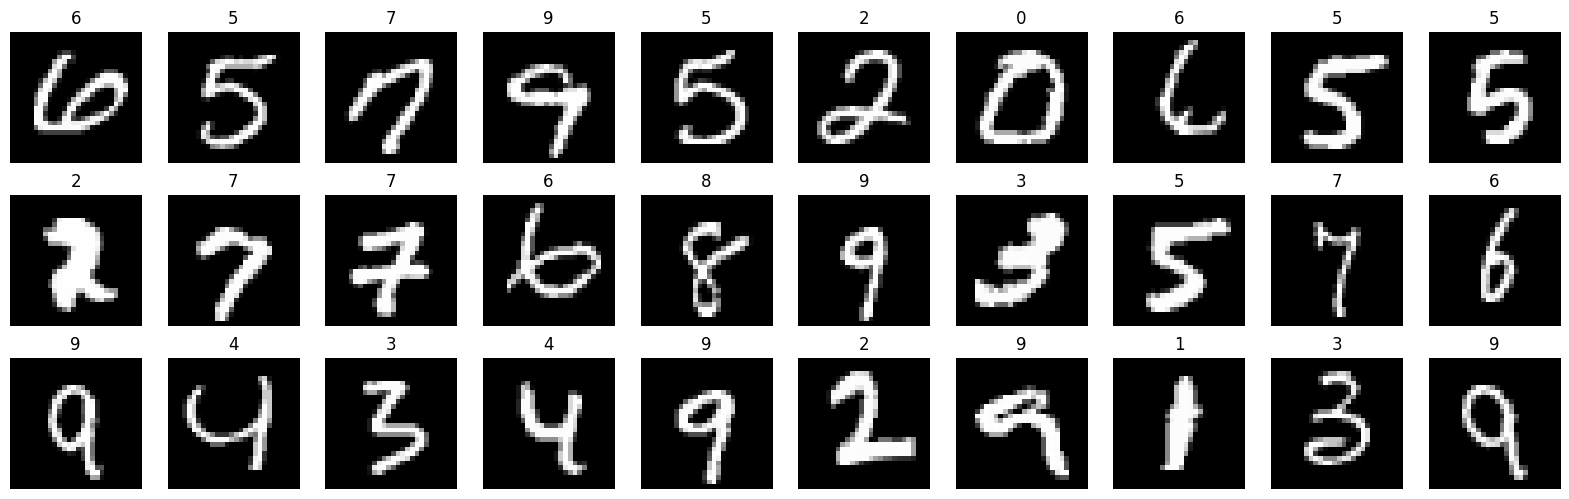

In [5]:
fig, axs = plt.subplots(ncols = 10, nrows = 3, figsize = (20,6))
axs = axs.reshape((-1,)) #  axes as linear format
for i in range(30):
  image_i = x_data[:,i].reshape((28,28))
  axs[i].imshow(image_i, cmap='gray')
  axs[i].set_title(int(labels[i]))
  axs[i].axis('off')

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.

In [72]:
len(labels)

20000

In [70]:
y_data = np.zeros((10, 20000))
for i in range(10):
  print(labels==i)
  y_data[i, labels==i] = 1

y_data

[False False False ... False False False]
[False False False ... False False False]
[False False False ...  True False False]
[False False False ... False False False]
[False False False ... False False False]
[False  True False ... False False  True]
[ True False False ... False False False]
[False False  True ... False False False]
[False False False ... False False False]
[False False False ... False  True False]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Check that the matrix has exactly one element "1" in each column.

In [12]:
row_sums = np.sum(y_data, axis = 0)
row_sums.min(), row_sums.max()

(1.0, 1.0)

## ANN training

Write a function to initialize the parameters (with Glorot Normal initialization) and a function implementing a feedforward ANN with tanh activation function.

To the last layer of the ANN, apply a *soft-max* layer. If $z_1, \dots, z_n$ are the activations of the last layer neurons, the soft-max layer produces $\hat{z}_1, \dots, \hat{z}_n$, defined as
$$
\hat{z}_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$
In this manner the outputs of the ANN satisfy by construction:
- $\hat{z}_i \in [0,1]$
- $\sum_{j=1}^n \hat{z}_j = 1$

Therefore, they can be intepreted as probabilities.

When the ANN will be trained, we will take the digit corresponding the the hightest proabability as prediction of the model.

In [65]:
'''
We take layers_size as a parameter: it is an array, i.e [8,5,4,1]

We return a list feeded with parameters, W and b

the Ws are matrices which collect the weights of the arcs linked between the layer and the previous layer
the bs are the bias of each layer

We alternate them

W are initialized with glorot normal initialization, while b with all zeros
'''
def initialize_params(layers_size):
    np.random.seed(0)
    params = list()
    for i in range(len(layers_size) - 1):
        print(i)
        W = np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt( 2 / (layers_size[i+1] + layers_size[i]))
        b = np.zeros((layers_size[i+1],1))
        params.append(W)
        params.append(b)
    return params

An Artificial Neural Network (ANN) is a function that takes some input 𝑥 (for example, pixel values of an image) and produces an output 𝑦^​ (for example, a probability distribution over classes). 
The ANN is composed of layers of neurons, where each layer performs a linear transformation followed by a non-linear activation function.

Layers: If we have a network with L layers, the input layer is layer 0, and the output layer is layer L. In between, we have hidden layers.

Parameters (Weights and Biases): Each layer (except the input layer) has parameters: weights (W) and biases (b). Weights connect the neurons from the previous layer to the current layer, and biases are added to shift the input to the activation function.

In [82]:
params = [784,20,20,10]
params[::2]

[784, 20]

Test the ANN and check that the above properties are satisfied.

In [ ]:
activation = jnp.tanh

def ANN(x, params):
  layer = x
  num_layers = int(len(params) / 2 + 1)
  weights = params[0::2]
  biases = params[1::2]
  for i in range(num_layers - 1):
    layer = weights[i] @ layer - biases[i]
    if i < num_layers - 2:
      layer = activation(layer)
  layer_exp = jnp.exp(layer)
  layer = layer_exp / np.sum(layer_exp, axis = 0)
  return layer

In [83]:
def ANN(x, params):
    # NOTE: we are workin with features/classes on rows and samples on columns
    # Thus, should we transpose x, like in previous lab?
    layer = x

    num_layers = int(len(params) / 2 ) + 1 # len(params) // 2 + 1
    weights = params[::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        print(weights[i])
        layer = jnp.dot(weights[i], layer) + biases[i]
        if i < num_layers - 2:
            layer =  jnp.tanh(layer)
    return jax.nn.softmax(layer, axis=0)


In [74]:
x_data.shape

(784, 20000)

In [84]:
y_pred = ANN(x_data, params)
y_pred_sum = jnp.sum(y_pred, axis=0)
jnp.min(y_pred_sum), jnp.max(y_pred_sum)

784
20


(Array(0.9999998, dtype=float32), Array(0.9999998, dtype=float32))

Implement the following metrics:
- mean square error
- cross entropy
- accuracy (fraction of samples correctly classified)

In [40]:
def MSE(x, y, params):
  y_pred = ANN(x, params)
  return jnp.mean((y - y_pred)**2)

def cross_entropy(x, y, params):
  y_pred = ANN(x, params)
  return -jnp.mean(jnp.sum(y * jnp.log(y_pred), axis=0))

def accuracy(x, y, params):
  y_pred = ANN(x, params)
  labels = jnp.argmax(y, axis = 0)
  labels_pred = jnp.argmax(y_pred, axis = 0)
  return jnp.mean(labels == labels_pred)


print('MSE:       %f' % MSE(x_data, y_data, params))
print('X entropy: %f' % cross_entropy(x_data, y_data, params))
print('accuracy:  %f' % accuracy(x_data, y_data, params))

MSE:       0.091300
X entropy: 2.370271
accuracy:  0.109250


In [36]:
y_pred = ANN(x_data, params)
labels = jnp.argmax(y_data, axis = 0)
labels.shape

(20000,)

Put 10000 images in the training set and 1000 images in the validation set.

In [55]:
idxs = np.random.permutation(20000)
x_data = x_data[:, idxs]
y_data = y_data[:, idxs]

x_train = x_data[:,:10000]
y_train = y_data[:,:10000]
x_valid = x_data[:,10000:]
y_valid = y_data[:,10000:]

x_train.shape

(784, 10000)

Run this cell. We will use it later.

In [41]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      epochs = np.arange(1,len(history_train_Xen) + 1)
      self.axs.loglog(epochs, history_train_Xen, label = 'train_Xen')
      self.axs.loglog(epochs, history_valid_Xen, label = 'valid_Xen')
      self.axs.loglog(epochs, history_valid_MSE, label = 'valid_MSE')
      self.axs.loglog(epochs, history_valid_acc, label = 'valid_acc')

      self.axs.legend()
      self.axs.set_title('epoch %d - accuracy %0.1f%%' % (self.epoch + 1, 100*history_valid_acc[-1]))

Train an ANN-based classifier with two hidden layers with 50 neurons each.
Use 500 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta = 10^{-7}$ and fixed learning rate $\lambda = 0.002$. Use minibatches with batch size of 1000.

Use the cross-entropy loss to drive the training.
To monitor training, store every 10 training epochs the following metrics in the following lists:
- `history_train_Xen`: cross-entropy (training set)
- `history_valid_Xen`: cross-entropy (validation set)
- `history_valid_MSE`: MSE (validation set)
- `history_valid_acc`: accuracy (validation set)

In [51]:
x_train.shape

(784,)

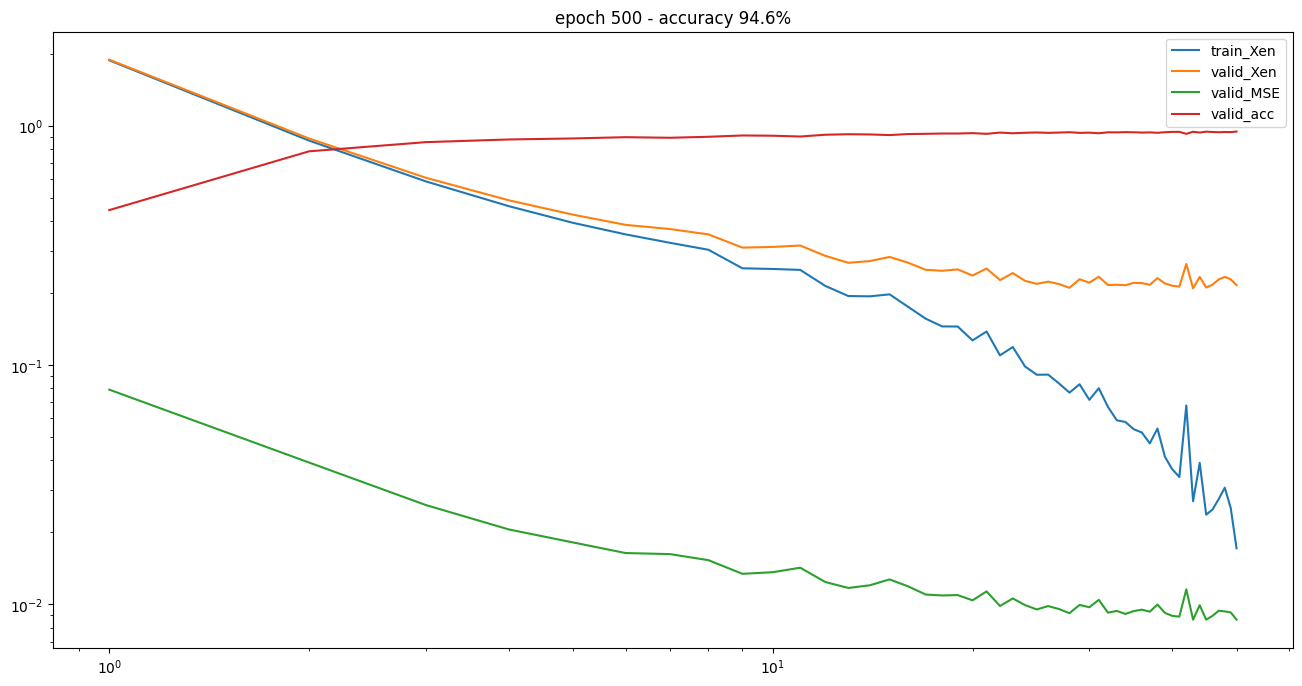

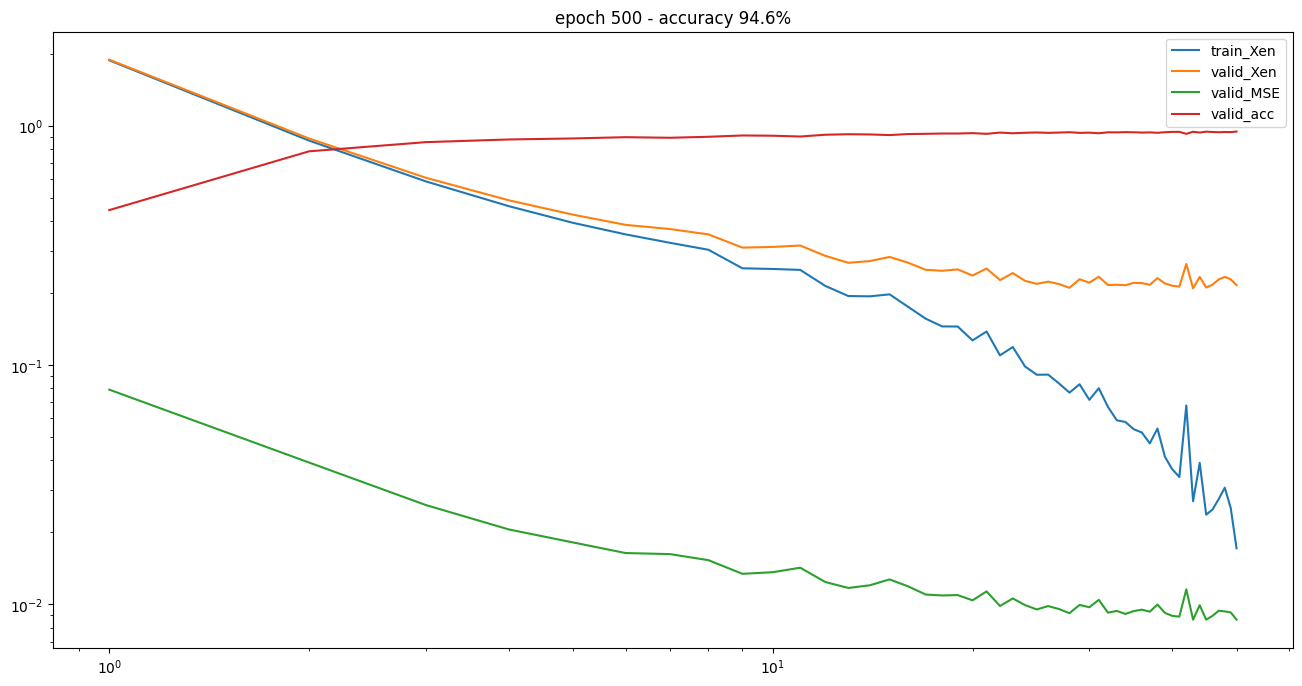

In [56]:
# Hyperparameters
layers_size = [784, 50, 50, 10]
n_train = 10000
# Training options
num_epochs = 500
batch_size = 1000
learning_rate = 2e-3
decay_rate = .9
delta = 1e-7

params = initialize_params(layers_size)

grad = jax.grad(cross_entropy, argnums = 2)
grad_jit = jax.jit(grad)

cross_entropy_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)



history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()
def dump():
  history_train_Xen.append(cross_entropy_jit(x_train, y_train, params))
  history_valid_Xen.append(cross_entropy_jit(x_valid, y_valid, params))
  history_valid_MSE.append(MSE_jit(x_valid, y_valid, params))
  history_valid_acc.append(accuracy_jit(x_valid, y_valid, params))

cb = Callback(refresh_rate=50)

cumulated_square_grad = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
  idxs = np.random.choice(10000, batch_size)
  grads = grad_jit(x_train[:,idxs], y_train[:,idxs], params)
  
  for i in range(len(params)):
    cumulated_square_grad[i] = decay_rate*cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  if epoch % 10 == 0: 
    dump()
  cb(epoch)
cb.draw()
    

## Testing

Load the dataset `sample_data/mnist_test.csv` and compute the accuracy of the classifier on this dataset.

In [58]:
data_test = np.genfromtxt('./mnist_test.csv', delimiter=',')
data_test.shape
labels_test = data_test[:,0]
x_test = data_test[:,1:].transpose() / 255
y_test = np.zeros((10, x_test.shape[1]))
for i in range(10):
  y_test[i, labels_test==i] = 1
x_test.shape, y_test.shape

((784, 10000), (10, 10000))

In [61]:
test_accuracy = accuracy_jit(x_test, y_test, params)
test_MSE = MSE_jit(x_test, y_test, params)
test_XEN = cross_entropy_jit(x_test, y_test, params)
print(f"test accuracy { test_accuracy * 100:.2f}%")
print(f"test MSE { test_MSE :.4e}")
print(f"test Xen { test_XEN :.4e}")

test accuracy 94.65%
test MSE 8.1149e-03
test Xen 1.9115e-01


Use the following script to visualize the predictions on a bunch of test images.

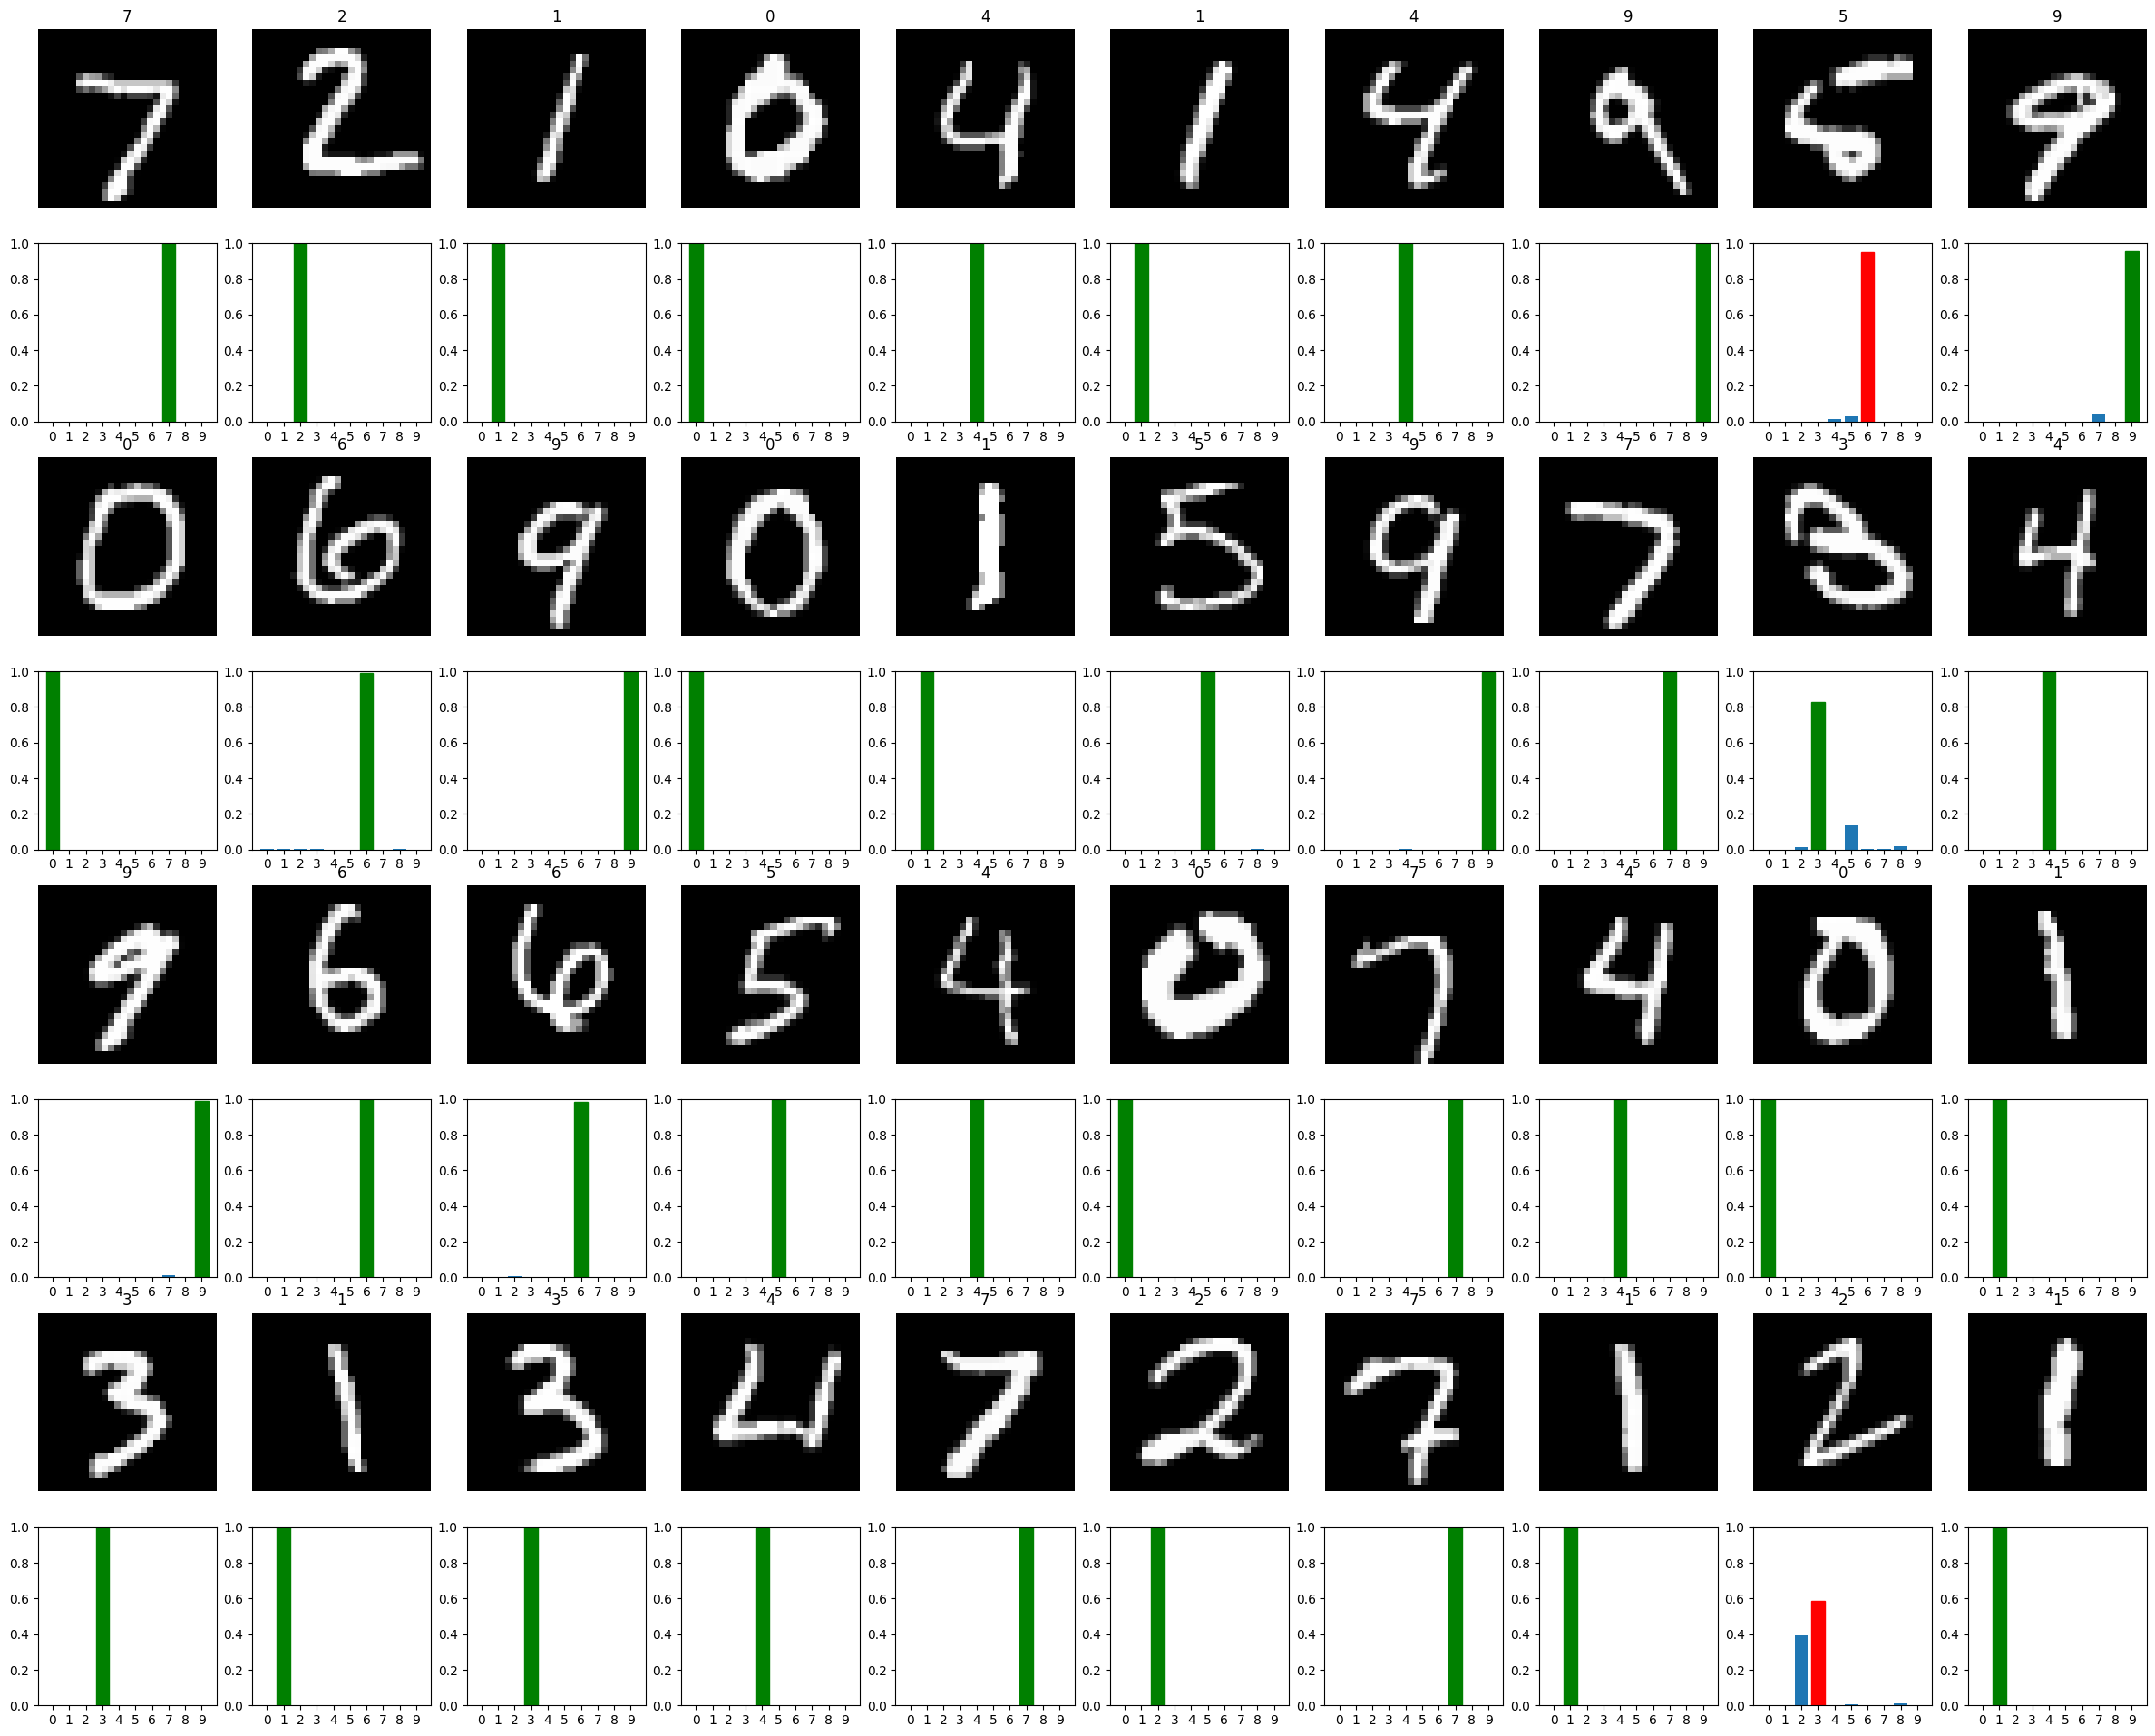

In [62]:
offset = 0
n_images = 40

images_per_row = 10
y_predicted = ANN(x_test[:,offset:offset+n_images], params)

def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0,1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
      color = 'green'
    else:
      color = 'red'
    myplot[label_predicted].set_color(color)

import math
n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize = (3*images_per_row, 3*n_rows))
row = 0
col = 0
for i in range(n_images):
  axs[2*row,col].imshow(x_test[:,offset+i].reshape((28,28)), cmap='gray')
  axs[2*row,col].set_title(int(labels_test[offset+i]))
  axs[2*row,col].axis('off')

  draw_bars(axs[2*row+1,col], y_predicted[:,i], labels_test[offset+i])

  col += 1
  if col == images_per_row:
    col = 0
    row += 1


# Adversarial attacks

You have trained your classifier. Cool, isn't it? Let us now try to fool it.

Consider the last image of the training set. Visualize it and visualize the associated predictions of the classifier.

In [ ]:
x = x_data[:,-1][:,None]
y = y_data[:,-1][:,None]
label = np.argmax(y)

_, axs = plt.subplots(1,2, figsize = (8,4))
axs[0].imshow(x.reshape((28,28)), cmap = 'gray')
axs[0].axis('off')

y_pred = ANN(x, params)

draw_bars(axs[1], y_pred[:,0], label)

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake.
See e.g. [this article](https://www.wired.com/story/tesla-speed-up-adversarial-example-mgm-breach-ransomware/)

To hack the classifier, compute the gradient of cross entropy loss funcion with respect to the input (not to the parameters!). Then, superimpose a multiple of the gradient to the original image.

Visualize the original and the hacked images and the corresponding prediction of the classifier.

In [ ]:
gradient = ...
x_updated = ...
y_updated = ...

_, axs = plt.subplots(1,5,figsize=(20,4))
axs[0].imshow(x.reshape((28,28)), cmap = 'gray')
axs[0].set_title('original picture')
draw_bars(axs[1], y_pred[:,0], label)
axs[2].imshow(gradient.reshape((28,28)), cmap = 'gray')
axs[2].set_title('gradient')
axs[3].imshow(x_updated.reshape((28,28)), cmap = 'gray')
axs[3].set_title('hacked picture')
draw_bars(axs[4], y_updated[:,0], label)